# LLM Watermark Judger

## Setup

Load necessary packages and initialize OpenAI API.

In [ ]:
# ----- SYSTEM PACKAGES ----- ##
import os
import sys

import time
import numpy as np

## ----- IMPORT FUNCTIONS ----- ##
sys.path.insert(0, os.getcwd())
from judgerfunctions import *

## Judge New Samples

Load sample pairs from a JSON file and use the GPT-judger to evaluate each sample, saving the results to the same data structure.

In [ ]:
## Judge New Samples
## Load sample pairs from a pickle file and use the GPT-judger to evaluate each sample, saving the results to JSON.

from judgerfunctions import *
import pickle
from evaluation.dataset import ClinicDataset

# Configuration variables - update these for different experiments
algorithm = "DIP"                  # Algorithm: "EXPEdit", "SWEET", "KGW", etc.
model = "jsl"                     # Model: "meditron", "biogpt", "opt", etc.
dataset = "HQA2"                        # Dataset: "MEQS", "HQA", "HQA2", etc.
gamma = 0.5                           # Optional parameter for some algorithms
delta = 2                           # Optional parameter for some algorithms
entropy = 0.9                         # Optional parameter for some algorithms
nlength = 256                          # Sequence length parameter for EXPEdit

# Determine task type based on dataset for appropriate judger prompt
if dataset in ['HQA']:
    task_type = 'GEN'  # Text completion/generation task
elif dataset in ['HQA2']:
    task_type = 'QA'   # Question-answering task
elif dataset in ['MEQS']:
    task_type = 'SUMM' # Summarization task
else:
    task_type = 'QA'   # Default to QA task

print(f"Using task type: {task_type} for dataset: {dataset}")

# Handle dataset paths similar to generate_simple.ipynb
if dataset == 'HQA':
    dataset_path = "dataset/hqa/hqa_processed_230words.json"
elif dataset == 'HQA2':
    dataset_path = "dataset/hqa2/hqa2_processed_4.json"
elif dataset == 'MEQS':
    dataset_path = "dataset/meqsum/meqsum_processed.json"

# Build the pickle file path based on algorithm parameters
dump_path = f"logs/{algorithm}"
if algorithm == "KGW" and gamma is not None and delta is not None:
    pickle_name = f'{algorithm}-g{gamma}-d{delta}-{model}-{dataset}.pkl'
elif algorithm == "SWEET" and entropy is not None and gamma is not None and delta is not None:
    pickle_name = f'{algorithm}-e{entropy}-g{gamma}-d{delta}-{model}-{dataset}.pkl'
elif algorithm == "EXPEdit" and nlength is not None:
    pickle_name = f'{algorithm}-n{nlength}-{model}-{dataset}.pkl'
elif algorithm == "DIP":
    pickle_name = f'{algorithm}-a0.45-{model}-{dataset}.pkl'
else:
    raise ValueError(f"Incomplete parameters for algorithm: {algorithm}")
pickle_path = os.path.join(dump_path, pickle_name)

print(f"Using pickle file: {pickle_path}")
print(f"Using dataset: {dataset_path}")

# Load dataset to get prompts
my_dataset = ClinicDataset(dataset_path)

# Load the watermarked, unwatermarked, and natural texts
with open(pickle_path, 'rb') as f:
    watermarked_texts, unwatermarked_texts, natural_texts = pickle.load(f)
 # NOTE (May 2): If the algorithm is EXPEdit and dataset is MEQS, we need to load the KGW data instead for unwatermarked texts
if algorithm == "EXPEdit" and dataset == "MEQS":
    temp_pickle_path = pickle_path.replace("EXPEdit", "KGW")
    temp_pickle_path = temp_pickle_path.replace(f"-n256", "-g0.5-d2")
    with open(temp_pickle_path, 'rb') as f:
        _, unwatermarked_texts, _ = pickle.load(f)

# Create output filename based on experiment parameters
output_filename = f"results_NEW2_judged_{pickle_name}.json"

# Initialize results list
data_list = []

# Create data structure for judging
for i in range(len(watermarked_texts)):
    prompt = my_dataset.get_prompt(i)
    item = {
        "sample_id": i,
        "prompt": prompt, 
        "w_output": watermarked_texts[i][len(prompt):],
        "uw_output": unwatermarked_texts[i][len(prompt):],
        "task_type": task_type  # Add task type to the data structure
    }
    data_list.append(item)

# Judge the samples
for i in range(len(data_list)):
    item = data_list[i]

    # Unpack needed fields
    prompt = item["prompt"]
    uw_output = item["uw_output"]
    w_output = item["w_output"]
    current_task_type = item["task_type"]

    # Evaluate responses using gpt with appropriate task type
    judge_choice = ""
    exception_counter = 0
    max_retries = 3
    while judge_choice == "" or judge_choice == "Model Failure":
        try:
            t1 = time.time()
            judge_output, judge_choice, scores_U, scores_W, is_randomized = gpt_judge(
                prompt, uw_output, w_output, task_type=current_task_type
            )
            t2 = time.time()
            break
        except Exception as e:
            exception_counter += 1
            print(f"\nError with sample {i}: {e}")
            if exception_counter >= max_retries:
                judge_output = ""
                judge_choice = "Error"
                scores_U = []
                scores_W = []
                is_randomized = None
                break
            time.sleep(2)  # Wait before retrying

    # Save results
    item["judge_output"] = judge_output
    item["randomized"] = is_randomized
    item["judge_choice"] = judge_choice
    item["scores_U"] = scores_U
    item["scores_W"] = scores_W
    item["evaluation_time"] = round(t2 - t1, 3) if judge_choice != "Error" else 0

    print(f"{i+1} out of {len(data_list)} items processed! Evaluation time: {item['evaluation_time']}s", end="\r")
    
    # Save results after each sample to avoid losing progress
    if (i+1) % 10 == 0 or i == len(data_list) - 1:
        save_to_json(data_list, filename=output_filename)

print(f"\nAll samples processed! Results saved to {output_filename}")
print(f"Task type used: {task_type}")

## Display Results

In [2]:
import json
from judgerfunctions import *

schemes = ["KGW", "SWEET", "EXPEdit","DIP"]
tasks = ["HQA", "HQA2", "MEQS"]
model_type = "meditron"

# load all json from directory that start with "results_judged_" to all_results
target_directory = "logs/GPTJUDGE-Results"
all_json_files = sorted([f for f in os.listdir(target_directory) if f.startswith("results_NEW2_judged_") and f.endswith(".json")])

all_json_files

['results_NEW2_judged_DIP-a0.45-meditron-HQA.pkl.json',
 'results_NEW2_judged_DIP-a0.45-meditron-HQA2.pkl.json',
 'results_NEW2_judged_DIP-a0.45-meditron-MEQS.pkl.json',
 'results_NEW2_judged_EXPEdit-n256-meditron-HQA.pkl.json',
 'results_NEW2_judged_EXPEdit-n256-meditron-HQA2.pkl.json',
 'results_NEW2_judged_EXPEdit-n256-meditron-MEQS.pkl.json',
 'results_NEW2_judged_KGW-g0.5-d2-meditron-HQA.pkl.json',
 'results_NEW2_judged_KGW-g0.5-d2-meditron-HQA2.pkl.json',
 'results_NEW2_judged_KGW-g0.5-d2-meditron-MEQS.pkl.json',
 'results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-HQA.pkl.json',
 'results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-HQA2.pkl.json',
 'results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-MEQS.pkl.json']

In [3]:
all_scores = {}
for scheme in schemes:
    for task in tasks:
        all_scores[scheme + "-" + task] = {
            "Watermarked": np.array([0.0,0.0,0.0]),
            "Unwatermarked": np.array([0.0,0.0,0.0]),
            "count_Watermarked": 0,
            "count_Unwatermarked": 0
        }

for scheme in schemes:
    for task in tasks:
        json_file = [f for f in all_json_files if scheme in f and task in f and ((task!="HQA") or (task == "HQA" and "HQA2" not in f)) and model_type in f][0] # must be only one

        print(f"Loading {json_file}...")

        # Load the results from the JSON file
        json_file_path = os.path.join(target_directory, json_file)
        data_list = load_from_json(filename=json_file_path)

        for i in range(len(data_list)):
            item = data_list[i]
            judge_choice = item["judge_choice"]
            if judge_choice != "Watermarked" and judge_choice != "Unwatermarked":
                continue
            all_scores[scheme + "-" + task]["Watermarked"] += np.array(item["scores_W"])
            all_scores[scheme + "-" + task]["Unwatermarked"] += np.array(item["scores_U"])
            all_scores[scheme + "-" + task]["count_Watermarked"] += 1
            all_scores[scheme + "-" + task]["count_Unwatermarked"] += 1

        # averaging
        all_scores[scheme + "-" + task]["Watermarked"] = all_scores[scheme + "-" + task]["Watermarked"] / all_scores[scheme + "-" + task]["count_Watermarked"]
        all_scores[scheme + "-" + task]["Unwatermarked"] = all_scores[scheme + "-" + task]["Unwatermarked"] / all_scores[scheme + "-" + task]["count_Unwatermarked"]

Loading results_NEW2_judged_KGW-g0.5-d2-meditron-HQA.pkl.json...
Loading results_NEW2_judged_KGW-g0.5-d2-meditron-HQA2.pkl.json...
Loading results_NEW2_judged_KGW-g0.5-d2-meditron-MEQS.pkl.json...
Loading results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-HQA.pkl.json...
Loading results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-HQA2.pkl.json...
Loading results_NEW2_judged_SWEET-e0.9-g0.5-d2-meditron-MEQS.pkl.json...
Loading results_NEW2_judged_EXPEdit-n256-meditron-HQA.pkl.json...
Loading results_NEW2_judged_EXPEdit-n256-meditron-HQA2.pkl.json...
Loading results_NEW2_judged_EXPEdit-n256-meditron-MEQS.pkl.json...
Loading results_NEW2_judged_DIP-a0.45-meditron-HQA.pkl.json...
Loading results_NEW2_judged_DIP-a0.45-meditron-HQA2.pkl.json...
Loading results_NEW2_judged_DIP-a0.45-meditron-MEQS.pkl.json...


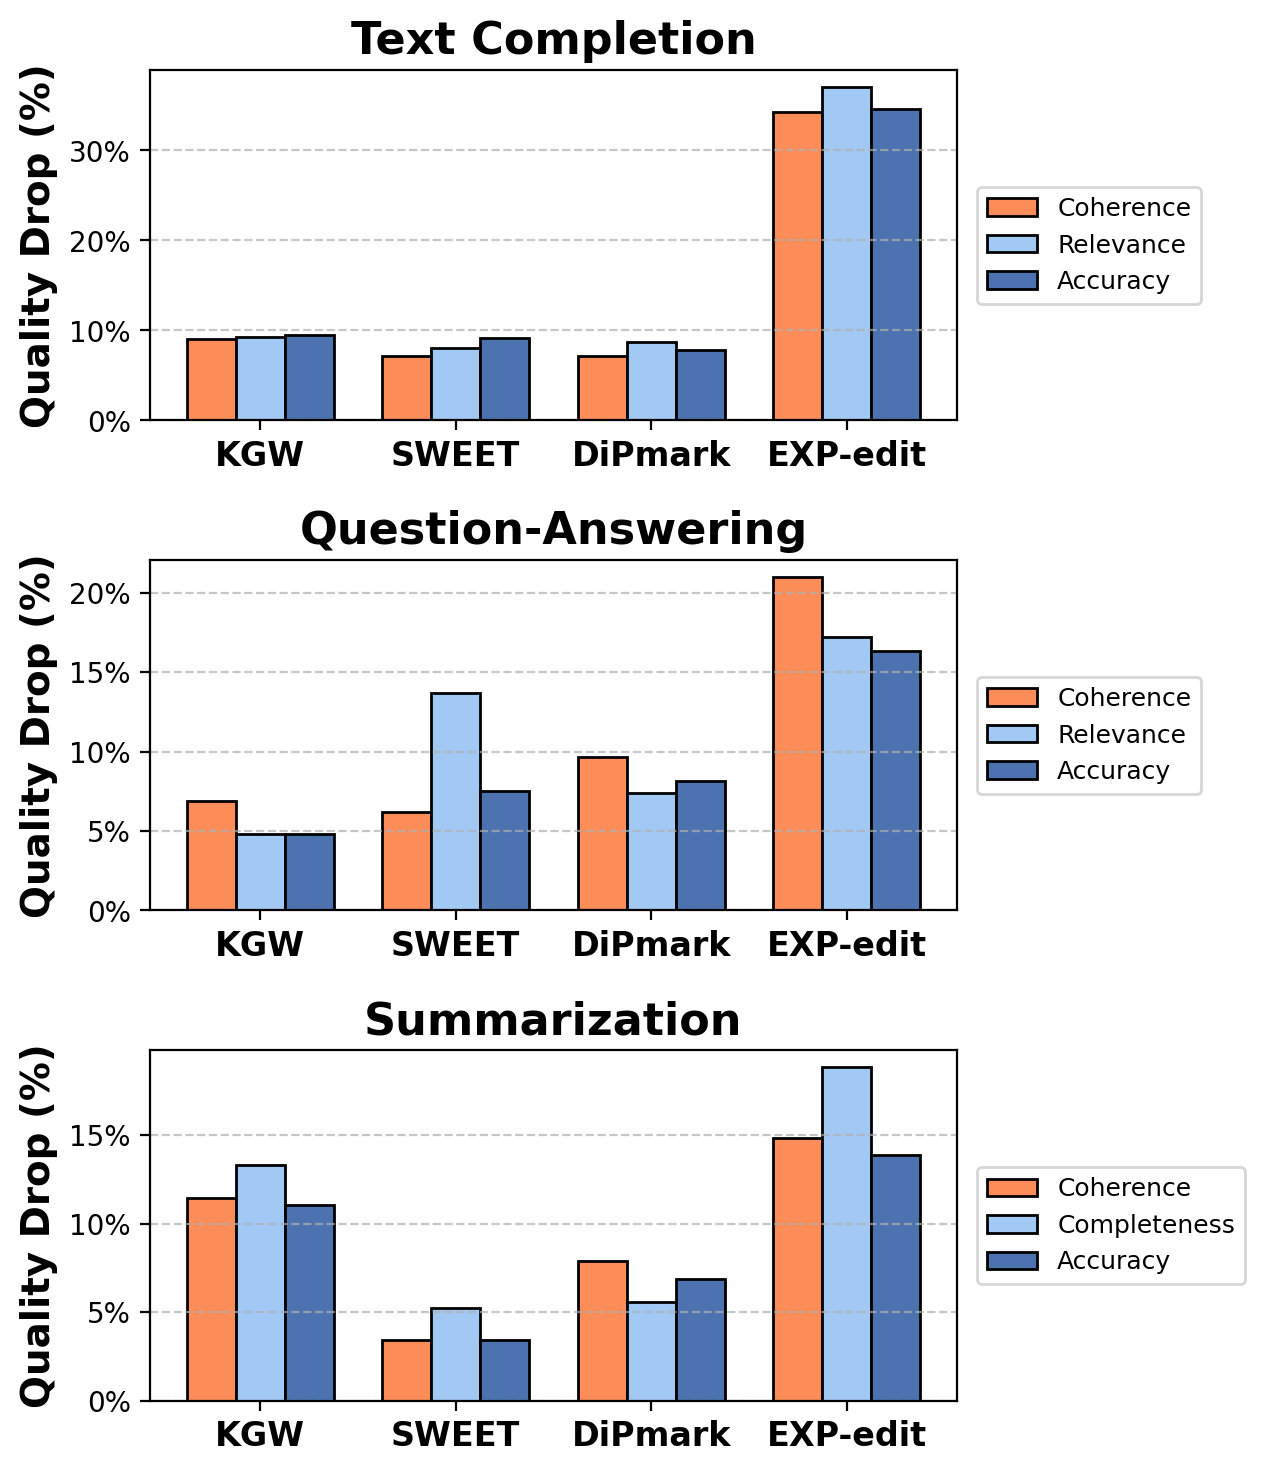

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

# Assuming all_scores is available with the same structure as in the original code
data = all_scores  

# Organize data by task
tasks = ['HQA', 'HQA2', 'MEQS']
schemes = ['KGW', 'SWEET', 'DIP','EXPEdit']
schemes_name = ['KGW', 'SWEET', 'DiPmark','EXP-edit']

# Set up color scheme for the categories
category_colors = ['#fc8d59', '#a1c9f4', '#4c72b0']

# Create a figure
plt.figure(figsize=(6, 8), dpi=200)

# Category names
category_names = {
    'HQA': ['Coherence', 'Relevance', 'Accuracy'],
    'HQA2': ['Coherence', 'Relevance', 'Accuracy'],
    'MEQS': ['Coherence', 'Completeness', 'Accuracy']
}
task_names = {
    'HQA': 'Text Completion',
    'HQA2': 'Question-Answering',
    'MEQS': 'Summarization'
}

# Calculate percentage drops
percentage_drops = {}
for task in tasks:
    for scheme in schemes:
        key = f'{scheme}-{task}'
        percentage_drops[key] = []
        for i in range(3):  # Three aspects/categories
            unwatermarked = data[key]['Unwatermarked'][i]
            watermarked = data[key]['Watermarked'][i]
            # Calculate percentage drop: (unwatermarked - watermarked) / unwatermarked * 100
            if unwatermarked > 0:  # Avoid division by zero
                drop = (unwatermarked - watermarked) / unwatermarked * 100
            else:
                drop = 0
            percentage_drops[key].append(drop)

# Create subplots for each task
for task_idx, task in enumerate(tasks):
    ax = plt.subplot(3, 1, task_idx + 1)
    
    x = np.arange(len(schemes))  # Position of scheme groups
    width = 0.25  # Width of bars
    
    # Offsets for the three aspect bars
    offsets = [-width, 0, width]
    
    # Create bars for each category
    for i in range(3):  # Three categories/aspects
        # Plot percentage drop bar for category i
        plt.bar(x + offsets[i], 
                [percentage_drops[f'{scheme}-{task}'][i] for scheme in schemes],
                width, 
                color=category_colors[i], 
                edgecolor='black',
                label=category_names[task][i])
    
    plt.ylabel('Quality Drop (%)', fontsize=14, fontweight='bold')
    plt.title(f'{task_names[task]}', fontsize=16, fontweight='bold')
    plt.xticks(x, schemes_name, fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage signs to y-axis
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    
    # Set y-axis limits
    plt.ylim(bottom=0)  # Start from 0%
    
    # Create legend for each subplot
    legend_elements = []
    
    # Add category colors to legend
    for i in range(3):
        legend_elements.append(Patch(facecolor=category_colors[i], 
                                    edgecolor='black',
                                    label=category_names[task][i]))
    
    # Add legend to the right of each subplot
    ax.legend(handles=legend_elements, 
              loc='center left', 
              bbox_to_anchor=(1.01, 0.5),
              fontsize=9)

plt.tight_layout(pad=3.0)
plt.subplots_adjust(hspace=0.4, right=0.85)  # Adjust right margin for legends
# plt.suptitle('Percentage Quality Drop After Watermarking', 
            #  fontsize=16, fontweight='bold', y=0.98)

plt.show()

In [5]:
methods = ["KGW", "SWEET","EXPEdit","DIP"]
tasks = ["MEQS"]
avg_methods_across_tasks = {}
for method in methods:
    tmp = []
    for task in tasks:
        key = f"{method}-{task}"
        tmp.append(percentage_drops[key])
    avg_methods_across_tasks[method] = np.mean(tmp, axis=0)
# print pretty with only 2 decimal places for all float numbers
for method in methods:
    print(f"{method}: {['{:.3f}'.format(x) for x in avg_methods_across_tasks[method]]}")

KGW: ['11.416', '13.287', '11.048']
SWEET: ['3.426', '5.238', '3.448']
EXPEdit: ['14.830', '18.832', '13.846']
DIP: ['7.872', '5.556', '6.890']
